In [2]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [3]:
mobilenet = models.mobilenet_v2(pretrained=True).features
for param in mobilenet.parameters():
    param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 73.1MB/s]


Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [4]:
def load_image(path, max_size=400, shape=None):
    image = Image.open(path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

def imconvert(tensor):
    tensor = tensor.cpu().clone().detach()
    tensor = tensor.numpy().squeeze()
    tensor = tensor.transpose(1,2,0)
    tensor = tensor * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    tensor = tensor.clip(0, 1)
    return tensor


In [5]:
def get_features(image, model, layers=None):
    if layers is None:
        # Adjust these layers for MobileNet
        layers = {'0': 'conv1_1', '3': 'conv2_1', '6': 'conv3_1', '13': 'conv4_1', '16': 'conv5_1'}
    
    features = {}
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
    
    return features

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


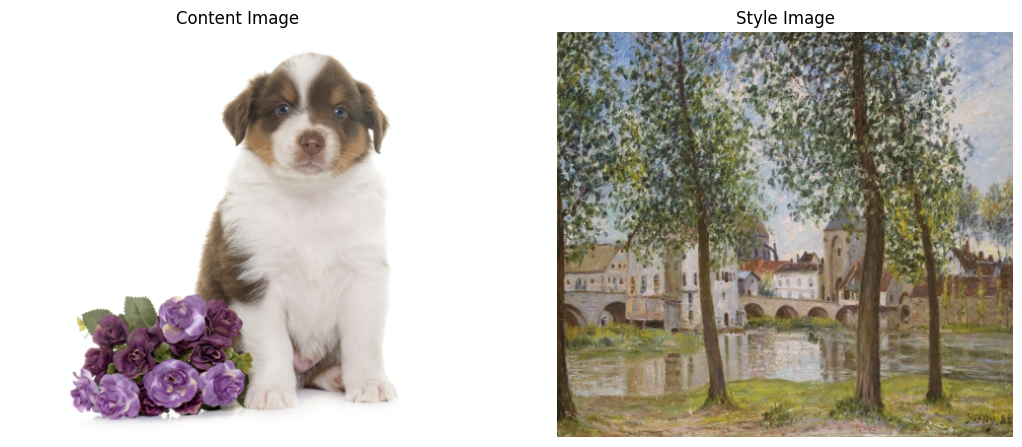

In [7]:
# Assuming content and style images are already loaded and processed
plt.figure(figsize=(20, 10))

content = load_image('/kaggle/input/jhdhsd/827959-Dogs-Australian-Shepherd-White-background-Sitting.jpg').to(device)
style = load_image('/kaggle/input/best-artworks-of-all-time/images/images/Alfred_Sisley/Alfred_Sisley_100.jpg', shape=content.shape[-2:]).to(device)


# Display content image
plt.subplot(1, 3, 1)
plt.title("Content Image")
plt.imshow(imconvert(content))
plt.axis('off')

# Display style image
plt.subplot(1, 3, 2)
plt.title("Style Image")
plt.imshow(imconvert(style))
plt.axis('off')

plt.show()


Step 0: Style Loss: 6.396945 Content Loss: 0.000000
Step 5000: Style Loss: 0.005843 Content Loss: 0.423538
Step 10000: Style Loss: 0.000248 Content Loss: 0.447193
Step 15000: Style Loss: 0.000076 Content Loss: 0.451948
Step 20000: Style Loss: 0.000042 Content Loss: 0.454137
Step 25000: Style Loss: 0.000037 Content Loss: 0.455370
Step 30000: Style Loss: 0.000051 Content Loss: 0.456413
Step 35000: Style Loss: 0.000033 Content Loss: 0.457140
Step 40000: Style Loss: 0.000034 Content Loss: 0.457555
Step 45000: Style Loss: 0.000017 Content Loss: 0.457800
Step 50000: Style Loss: 0.000016 Content Loss: 0.458216
Step 55000: Style Loss: 0.000014 Content Loss: 0.458591


<function matplotlib.pyplot.show(close=None, block=None)>

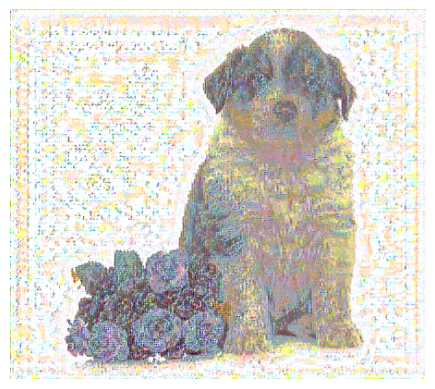

In [6]:
# Load your images here
content = load_image('').to(device)
style = load_image('/kaggle/input/best-artworks-of-all-time/images/images/Alfred_Sisley/Alfred_Sisley_100.jpg', shape=content.shape[-2:]).to(device)

content_features = get_features(content, mobilenet)
style_features = get_features(style, mobilenet)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

# Weights and optimizer
style_weights = {'conv1_1': 1.0, 'conv2_1': 0.8, 'conv3_1': 0.5, 'conv4_1': 0.3, 'conv5_1': 0.1}
content_weight = 1
style_weight = 1e6
optimizer = torch.optim.Adam([target], lr=0.003)

# Style transfer loop
steps = 60000  # Adjust as needed
for i in range(steps):
    target_features = get_features(target, mobilenet)
    content_loss = torch.mean((target_features['conv4_1'] - content_features['conv4_1'])**2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % 5000 == 0:
        print('Step {}: Style Loss: {:4f} Content Loss: {:4f}'.format(i, style_loss.item(), content_loss.item()))

# Display and save the final image
final_img = imconvert(target)
plt.imshow(final_img)
plt.axis('off')
plt.show
